In this notebook we will demonstrate some more advanced visualizations of MiniSom results.

In [1]:
from __future__ import annotations
from typing import Any
import snowflake.snowpark as snowpark
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.window as W
import snowflake.snowpark.types as T
import pandas as pd
import numpy as np
import altair as alt
import json
import random
import math
import uuid
pd.set_option('display.max_columns', 500)
USER = "BAMENDOLA" #for snowflake
PASS = "Bryceapril61995" #for snowflake
snowflake_credentials = {
  "account" : "KGA92485",
  "user" : USER,
  "password" : PASS,
  "role" : "SYSADMIN",
  "database" : "DATA_SCIENCE",
  "schema" : "PUBLIC",
  "warehouse" : "DATASCIENCE_XLARGE_WH"
}
session = Session.builder.configs(snowflake_credentials).create()

/opt/anaconda3/envs/env/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


In [2]:
def join(s1: str, s2: str):
    if s1[-1] == '"':
        return s1[:-1]+s2+'"'
    else:
        return s1+s2
    
class Kmeans(object):
    def __init__(self, k: int,*args):
        super(Kmeans, self).__init__(*args)
        self.k = k
        self.cluster_id = 'CLUSTER_ID'
        self.cluster = session.createDataFrame(data=[ v for v in range(self.k)],schema=T.StructType([T.StructField(self.cluster_id, T.IntegerType())]))
        self.prediction = None
        self.run_id = None
    def initializeCluster(self,df: snowpark.DataFrame,inputCols: str) -> snowpark.DataFrame:
        return df.crossJoin(self.cluster).groupBy(F.col(self.cluster_id)) \
            .agg([F.min(F.col(c)).alias(c+'_min') for c in inputCols]+[F.max(F.col(c)).alias(c+'_max') for c in inputCols]) \
            .select([self.cluster_id]+[(F.uniform(F.lit(0.0),F.lit(1.0), F.random())*(F.col(c+'_max')-F.col(c+'_min'))+F.col(c+'_min')).alias(c) for c in inputCols])
    def initializeCluster2(self,df: snowpark.DataFrame, inputCols: str):
        return df.sample(n=self.k).select([F.col(c) for c in inputCols]+[F.row_number().over(W.Window.orderBy(F.lit(None))).alias(self.cluster_id)])
    def distance(self,df: snowpark.DataFrame,id: str,inputCols: str) -> snowpark.DataFrame:
        return df.crossJoin(self.cluster,lsuffix='_L',rsuffix='_R') \
            .select(F.col(id) if id != self.cluster_id else F.col(join(id,'_L')),F.col(self.cluster_id) if id != self.cluster_id else F.col(join(self.cluster_id,'_R')),F.sqrt(sum([F.pow(F.col(join(c,'_L'))-F.col(join(c,'_R')),F.lit(2)) for c in inputCols])).alias('distance'),F.row_number().over(W.Window.partitionBy(F.col(id) if id != self.cluster_id else F.col(join(id,'_L'))).orderBy(F.col('distance').asc())).alias('r'))\
            .select(F.col(id) if id != self.cluster_id else F.col(join(id,'_L')),F.col(self.cluster_id) if id != self.cluster_id else F.col(join(self.cluster_id,'_R')),F.col('distance'),F.col('r'))
    def fit(self,df: snowpark.DataFrame,id: str,inputCols: str,maxIter=None,initialize=True) -> Kmeans:
        if initialize:
            self.cluster = self.initializeCluster2(df,inputCols).cache_result()
        prediction = self.transform(df,id,inputCols).cache_result()
        iteration = 0
        self.run_id = str(uuid.uuid4())
        while (self.prediction == None or (self.prediction.except_(prediction).count() > 0)) and (maxIter==None or iteration < maxIter):
            print('run_id:',self.run_id,',iteration:',iteration) 
            self.prediction = prediction
            print(self.prediction.groupBy(F.col(self.cluster_id)).agg(F.count('*')).orderBy(F.col(self.cluster_id)).toPandas())
            self.cluster = df.join(self.prediction,[id]).groupBy(F.col(self.cluster_id)).agg([ F.mean(c).alias(c) for c in inputCols]) \
                .union(self.cluster.where(F.col(self.cluster_id).isin(self.prediction.select(F.col(self.cluster_id))) == F.lit(False))).cache_result()
            prediction = self.transform(df,id,inputCols).cache_result()
            iteration += 1
            self.cluster.select(F.col('*'),F.lit(iteration).alias('t'),F.lit(self.run_id).alias('run_id')).write.mode('append').save_as_table('kmeans_t2')
        return self
    
    def transform(self,df: snowpark.DataFrame,id: str,inputCols: str) ->snowpark.DataFrame:
        return self.distance(df,id,inputCols).where(F.col('r') == F.lit(1)).select(F.col(id),F.col(self.cluster_id))
    
    
class SOM(object):
    # https://www.osti.gov/servlets/purl/1566795
    def __init__(self,k : int=None,h : int=None,w : int=None,sigma : float=1.0 ,lr : float=1.0 ,*args):
        super(SOM, self).__init__(*args)
        if w is None and h is None:
            self.h = k
            self.w = k
            self.k = k**2
        else:
            self.h = h
            self.w = w
        self.lr = lr
        self.sigma = sigma
        self.cluster_id = 'CLUSTER_ID'
        self.cluster = session.createDataFrame(data=[ v for v in range(self.k)],schema=T.StructType([T.StructField(self.cluster_id, T.IntegerType())]))
        self.neighbor = self.cluster.crossJoin(self.cluster,lsuffix='_L',rsuffix='_R')\
            .select(F.col(join(self.cluster_id,'_L')).alias('BMI_ID'),F.col(join(self.cluster_id,'_R')).alias(self.cluster_id),(F.pow(F.col(join(self.cluster_id,'_L'))%F.lit(self.w)-F.col(join(self.cluster_id,'_R'))%F.lit(self.w),F.lit(2))+F.pow(F.floor(F.col(join(self.cluster_id,'_L'))/F.lit(self.h))-F.floor(F.col(join(self.cluster_id,'_R'))/F.lit(self.h)),F.lit(2))).alias('distance')).cache_result()
        self.run_id = None
    def initializeCluster(self,df: snowpark.DataFrame, inputCols: str) -> snowpark.DataFrame:
        return df.crossJoin(self.cluster).groupBy(F.col(self.cluster_id)) \
            .agg([F.min(F.col(c)).alias(c+'_min') for c in inputCols]+[F.max(F.col(c)).alias(c+'_max') for c in inputCols]) \
            .select([self.cluster_id]+[(F.uniform(F.lit(0.0),F.lit(1.0), F.random())*(F.col(c+'_max')-F.col(c+'_min'))+F.col(c+'_min')).alias(c) for c in inputCols])
    def initializeCluster2(self,df: snowpark.DataFrame, inputCols: str):
        return df.sample(n=self.k).select([F.col(c) for c in inputCols]+[(F.row_number().over(W.Window.orderBy(F.lit(None)))-F.lit(1)).alias(self.cluster_id)])
    def distance(self,df: snowpark.DataFrame,id: str,inputCols: str) -> snowpark.DataFrame:
        return df.crossJoin(self.cluster,lsuffix='_L',rsuffix='_R') \
            .select(F.col(id) if id != self.cluster_id else F.col(join(id,'_L')),F.col(self.cluster_id) if id != self.cluster_id else F.col(join(self.cluster_id,'_R')),F.sqrt(sum([F.pow(F.col(join(c,'_L'))-F.col(join(c,'_R')),F.lit(2)) for c in inputCols])).alias('distance'),F.row_number().over(W.Window.partitionBy(F.col(id) if id != self.cluster_id else F.col(join(id,'_L'))).orderBy(F.col('distance').asc())).alias('r'))\
            .select(F.col(id) if id != self.cluster_id else F.col(join(id,'_L')),F.col(self.cluster_id) if id != self.cluster_id else F.col(join(self.cluster_id,'_R')),F.col('distance'),F.col('r'))
    def getNeighborHood(self,inputCols: str, sigma: float) -> snowpark.DataFrame:
        return self.cluster.crossJoin(self.cluster,lsuffix='_L',rsuffix='_R')\
            .select([F.col(join(self.cluster_id,'_L')).alias('BMI_ID')]+[F.col(join(c,'_R')).alias(c) for c in self.cluster.columns]+[F.sqrt(sum([F.pow(F.col(join(c,'_L'))-F.col(join(c,'_R')),F.lit(2)) for c in inputCols])).alias('distance'),F.when(F.lit(sigma)>F.lit(0.0),F.exp(-F.pow(F.col('distance'),2)/(F.lit(2)*F.pow(sigma,2)))).otherwise(F.when(F.col('distance')==F.lit(0.0),F.lit(1.0)).otherwise(F.lit(0.0))).alias('influence_rate')])
                    
    def getNeighborHood2(self,inputCols: str, sigma: float) -> snowpark.DataFrame:
        return self.cluster.join(self.neighbor,[self.cluster_id],lsuffix='_L',rsuffix='_R')\
            .select([F.col('BMI_ID')]+[F.col(self.cluster_id).alias(self.cluster_id)]+[F.col(c) for c in self.cluster.columns if c != self.cluster_id]+[F.when(F.lit(sigma)>F.lit(0.0),F.exp(-F.col('distance')
                                                                                                                                                                                             /(F.lit(2)*F.pow(sigma,2)))).otherwise(F.when(F.col('distance')==F.lit(0.0),F.lit(1.0)).otherwise(F.lit(0.0))).alias('influence_rate')])
    def convertToCoord(self,df: snowpark.DataFrame):
            return self.cluster.select(F.col(self.cluster_id),(F.col(self.cluster_id)%F.lit(self.w)).alias('x'),F.floor(F.col(self.cluster_id)/F.lit(self.h)).alias('y')).join(df,self.cluster_id)
    def fit(self,df: snowpark.DataFrame,id: str,inputCols: str,maxIter=5, batchSize=None,initialize=True) -> SOM:
        if initialize:
            self.cluster = self.initializeCluster2(df,inputCols).cache_result()
        iteration = 0
        lr=self.lr
        sigma=self.sigma
        maxIter = maxIter if batchSize==None else maxIter*(df.count()/batchSize)
        time_constant = maxIter
        self.run_id = str(uuid.uuid4())
        while iteration < maxIter:
            print('run_id:',self.run_id,',iteration:',iteration,',lr:',lr,',sigma:',sigma) 
            sample = df if batchSize==None else df.sample(n=batchSize).cache_result()
            bmu = self.distance(sample,id,inputCols).where(F.col('r') == F.lit(1)).drop(F.col('r')).rename(self.cluster_id,'BMI_ID').cache_result()
            #print(bmu.groupBy(F.col('BMI_ID')).agg(F.count('*')).orderBy(F.col('BMI_ID').toPandas())
            neighborhood = self.getNeighborHood2(inputCols,sigma).cache_result()
            self.cluster = sample.join(bmu,id).join(neighborhood,on='BMI_ID',lsuffix='_L',rsuffix='_R').select([F.col(self.cluster_id)]+[(F.col(join(c,'_R'))+F.lit(lr)*(F.col('influence_rate')*(F.col(join(c,'_L'))-F.col(join(c,'_R'))))).alias(c) for c in inputCols]) \
                .groupBy(F.col(self.cluster_id)).agg([F.mean(c).alias(c) for c in inputCols]).cache_result()
                # .union(self.cluster.where(F.col(self.cluster_id).isin(neighborhood.select(F.col(self.cluster_id))) == F.lit(False))) is not needed as the 'influence_rate' is zero where the neighbors are out of range 
            iteration += 1
            lr=self.lr*math.exp(-iteration/time_constant)
            #sigma=self.sigma*math.exp(-iteration/time_constant)
            coefficient = 1.0 - (float(iteration)/time_constant)
            #lr=self.lr*coefficient
            sigma=self.sigma*coefficient
            self.cluster.select(F.col('*'),F.lit(iteration).alias('t'),F.lit(self.run_id).alias('run_id')).write.mode('append').save_as_table('som_t2')
        return self
    
    def transform(self,df: snowpark.DataFrame,id: str,inputCols: str):
        return self.distance(df,id,inputCols).where(F.col('r') == F.lit(1)).select(F.col(id),F.col(self.cluster_id))

In [3]:
data_cluster = session.read.table('cluster').cache_result()
data_meta = session.read.table('cluster_meta').cache_result()
df = session.read.table('EXTENDED_ATTRIBUTES_CONSOLIDATED_SAMPLE').cache_result()

In [5]:
from minisom import MiniSom

For this example we will again load the <a href="https://archive.ics.uci.edu/ml/datasets/seeds">seeds</a> dataset dataset using pandas:

In [6]:
import pandas as pd
import numpy as np
id_ = 'UNIVERSAL_ID'
columns = [c for c in df.columns if c != id_]
data = df.sample(n=10000).toPandas()
data['target'] = 0
target = data['target'].values
label_names = {0:'noclass'}
data = data.drop([id_,'target'],axis=1)
# data normalization
#data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

/opt/anaconda3/envs/env/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


We can initialize and train MiniSom as follows:

In [7]:
def getModel(meta,df,run_id):
    p = json.loads(meta.where(F.col('run_id') == F.lit(run_id)).select(F.col('PARAM')).toPandas().values[0,0])
    m = Kmeans(k=p['k']) if p['model_name'] == 'kmeans' else SOM(k=p['k'],sigma=p['sigma'],lr=p['lr'])
    m.cluster = df.where(F.col('run_id') == F.lit(run_id)).select([F.col(c) for c in df.columns if c not in ('RUN_ID')]).cache_result()
    return m
model = getModel(data_meta,data_cluster,'ea4b337f-46b5-4bb8-a0d9-d4d839f6e8ca')

In [8]:
n_neurons = model.w
m_neurons = model.h
som = MiniSom(n_neurons, m_neurons, len(columns), sigma=model.sigma, learning_rate=model.lr, 
              neighborhood_function='gaussian', random_seed=0)

som._weights = model.cluster.orderBy(model.cluster_id).drop(model.cluster_id).toPandas().to_numpy().reshape(model.w,model.h,-1).transpose(1,0,2)


To visualize the quality of clustering of each neuron this map uses colors to show the mean difference of the values corresponding to a neuron and the weights of the neuron. Neurons that aren't winning neuron for any sample are left blank.

In [9]:
import plotly.graph_objects as go

win_map = som.win_map(data)
size=som.distance_map().shape[0]
qualities=np.empty((size,size))
qualities[:]=np.NaN
for position, values in win_map.items():
    qualities[position[0], position[1]] = np.mean(abs(values-som.get_weights()[position[0], position[1]]))

layout = go.Layout(title='quality plot')
fig = go.Figure(layout=layout)
fig.add_trace(go.Heatmap(z=qualities, colorscale='Viridis'))
fig.show()

The property plot shows the mean values of each neuron seperately plotted for each property. This view can be used to explore the "correlation" of properties.

In [22]:
from plotly.subplots import make_subplots
import math
def showPropertyPlot(som, data, columns):
# plots the distances for each different property
    win_map = som.win_map(data)
    size=som.distance_map().shape[0]
    properties=np.empty((size*size,2+data.shape[1]))
    properties[:]=np.NaN
    i=0
    for row in range(0,size):
        for col in range(0,size):
            properties[size*row+col,0]=row
            properties[size*row+col,1]=col

    for position, values in win_map.items():
        properties[size*position[0]+position[1],0]=position[0]
        properties[size*position[0]+position[1],1]=position[1]
        properties[size*position[0]+position[1],2:] = np.mean(values, axis=0)
        i=i+1

    B = ['row', 'col']
    B.extend(columns)
    print('p:',properties.shape,len(B),len(columns))
    properties = pd.DataFrame(data=properties, columns=B)
    
    fig = make_subplots(rows=math.ceil(math.sqrt(data.shape[1])), cols=math.ceil(math.sqrt(data.shape[1])), shared_xaxes=False, horizontal_spacing=0.05, vertical_spacing=0.05, subplot_titles=columns, column_widths=None, row_heights=None)
    i=0
    zmin=min(np.min(properties.iloc[:,2:]))
    zmax=max(np.max(properties.iloc[:,2:]))
    for property in columns:
        fig.add_traces(
            [go.Heatmap(z=properties.sort_values(by=['row', 'col'])[property].values.reshape(size,size), zmax=zmax, zmin=zmin, coloraxis = 'coloraxis2')],
            rows=[i // math.ceil(math.sqrt(data.shape[1])) + 1 ],
            cols=[i % math.ceil(math.sqrt(data.shape[1])) + 1 ]
            )
        i=i+1

    for layout in fig.layout:
        if layout.startswith('xaxis') or layout.startswith('yaxis'):
            fig.layout[layout].visible=False
            fig.layout[layout].visible=False
        if layout.startswith('coloraxis'):
            fig.layout[layout].cmax=zmax
            fig.layout[layout].cmin=zmin
        if layout.startswith('colorscale'):
            fig.layout[layout]={'diverging':'viridis'}

    fig.update_layout(
        height=4000,
        width=4000
    )
    fig.show()
    
showPropertyPlot(som, data, columns)

p: (9, 111) 111 109


/opt/anaconda3/envs/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'

/opt/anaconda3/envs/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



The distribution map shows the min, max and mean of the values of samples corresponding with a neuron. Each neuron's data is shown in an own subplot. This plot can be used to examine similarities or differences in the neuron weights.
In this example of supervised learning, I have shown the main class of each neuron (as major class of all samples of a neuron) via background color of the subplots.

In [11]:
def distributionMap(data, clusters, size, columns, minimum, maximum, plottype='barpolar'):
    spec={"type": "polar"}
    fig = make_subplots(rows=size, cols=size, specs=np.full((size,size),spec).tolist(), shared_yaxes=True, shared_xaxes=True,horizontal_spacing=0, vertical_spacing=0, subplot_titles=None, column_widths=None, row_heights=None)
    categories=columns
    if plottype=='spider':
        for index, row in data.iterrows():
            fig.add_traces(
                [go.Scatterpolargl(
                    r=row['max'],
                    name='max',
                    fillcolor='green',
                    line=dict(color='green'),
                    theta=categories,           
                    opacity=0.5),
                go.Scatterpolargl(
                    r=row['mean'],
                    name='mean',
                    fillcolor='blue',
                    line=dict(color='blue'),
                    theta=categories,           
                    opacity=0.5),
                go.Scatterpolargl(
                    r=row['min'],
                    name='min',
                    fillcolor='red',
                    line=dict(color='red'),
                    theta=categories,           
                    opacity=0.5)],
                rows=[row['row'], row['row'], row['row']],
                cols=[row['col'], row['col'], row['col']]
                )
    else:
        for index, row in data.iterrows():
            fig.add_traces(
                [
                go.Barpolar(                   
                    base=minimum,
                    r=row['max']-minimum,
                    name='max'+str(index),
                    marker_color="green",
                    theta=categories,           
                    #opacity=1
                 ),
                go.Barpolar(           
                    base=minimum,
                    r=row['mean']-minimum,
                    name='mean'+str(index),
                    marker_color="blue",
                    theta=categories,           
                    #opacity=1
                 ),
                go.Barpolar(           
                    base=minimum,
                    r=row['min']-minimum,
                    name='min'+str(index),
                    marker_color="darkred",
                    theta=categories,  
                    #opacity=1
                ) 
                ],
                rows=[row['row'], row['row'], row['row']],
                cols=[row['col'], row['col'], row['col']]
                )        

    if plottype=='spider':
        fig.update_traces(mode='lines', fill='toself')
    for layout in fig.layout:
        if layout.startswith('polar'):
            fig.layout[layout].angularaxis.visible=False
            fig.layout[layout].angularaxis.tickfont.size = 7
            fig.layout[layout].radialaxis.visible=True
            fig.layout[layout].radialaxis.tickfont.size = 7
            fig.layout[layout].barmode='overlay'
            fig.layout[layout].radialaxis.range = [minimum, maximum+1]

    for index, row in data.iterrows():
            color=row['bgcolor']
            if row['row']==0 and row['col']==0:
                # row needs to be switched because all the other plots (heatmaps) are shown with row 0 at bottom 
                fig.layout['polar'].bgcolor="rgb("+",".join(str(i) for i in [color]*3) +")"
            else:
                # row needs to be switched because all the other plots (heatmaps) are shown with row 0 at bottom 
                fig.layout['polar'+str((row['row']-1)*size+row['col'])].bgcolor="rgb("+",".join(str(i) for i in [color]*3) +")"
            
    fig.update_layout(
        width=900,
        height=900,
        showlegend=False
    )

    fig.show()

In [12]:
def plotDistributionOfDataInClusters(som, data, columns, plottype='barpolar'): 
    size=som.distance_map().shape[0]
    clusters= np.array(np.arange(0,size*size)).reshape(size,size)
    distributionMapData=pd.DataFrame(columns=['col', 'row', 'min', 'mean', 'max', 'bgcolor'])
    labels_map = som.labels_map(data, [label_names[t] for t in target])
    win_map=som.win_map(data)
    for position in win_map.keys():
        label_fracs = [labels_map[position][l] for l in label_names.values()]
        bgcolor = label_fracs.index(np.max(label_fracs))*255//len(label_fracs) 
        winner=win_map[position]
        minima=np.min(winner, axis=0)
        means=np.mean(winner, axis=0)
        maxima=np.max(winner, axis=0)
        row=int(position[1]+1)
        col=int(position[0]+1)
        distributionMapData=distributionMapData.append(
            {'col': col,
             # row needs to be shifted because all the other plots (heatmaps) are shown with row 0 at bottom 
             'row': size-row+1, 
             'min': minima, 
             'mean': means, 
             'max': maxima,
             'bgcolor' : bgcolor}, 
             verify_integrity=True, ignore_index=True)

    noClusters=np.max(clusters).item()+1
    clusterData=pd.DataFrame(columns=['col', 'row', 'min', 'mean', 'max'])
    
    maximum=max([l.max() for l in distributionMapData['max'].values])
    minimum=min([l.min() for l in distributionMapData['min'].values])
    
    distributionMap(distributionMapData, clusters, size, columns, minimum, maximum, plottype)

plotDistributionOfDataInClusters(som, data, columns[:-1], plottype='barpolar')

/var/folders/7f/g_mmpybs1w3gw13s96ryn7x00000gp/T/ipykernel_963/102937540.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/7f/g_mmpybs1w3gw13s96ryn7x00000gp/T/ipykernel_963/102937540.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/7f/g_mmpybs1w3gw13s96ryn7x00000gp/T/ipykernel_963/102937540.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/7f/g_mmpybs1w3gw13s96ryn7x00000gp/T/ipykernel_963/102937540.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/7f/g_mmpybs1w3gw13s96ryn7x00000gp/T/ipykernel_963/102937540.py:16: FutureWarning:

The frame.append method is deprecated and wi

### Starburst Gradient visualization
This visualization can be used to find similaraties between neurons resp. between the samples that are represented. the black lines follow the maximum gradient between nodes, the stars separate regions of neurons with smaller distance towards each other from others.

If you image the UMAT (distance values) being plotted as 3 dimensional plot lile mountains and valleys the starburst map shows the at the center of the stars the position a ball would end up when it started rolling at the begin of one of the corresponding lines. 

From Hamel, Brown: Improved Interpretability of the Unified Distance Matrix with Connected Components (https://homepage.cs.uri.edu/faculty/hamel/pubs/improved-umat-dmin11.pdf)

"At the core of the implementation is the function find.internal.node which, given the map coordinates of a neural element, will find the corresponding internal node of the associated star. [...] Given a position on the map this function first searches the adjacent nodes for the minimal UMAT value using the function find.min. If an adjacent node with a smaller UMAT value than the value of our current node exists and if this UMAT value is smaller than the UMAT values of all other adjacent nodes, then that node lies along the maximum gradient of the surface and we make this node our new current position. If no such node exists, then the gradient at our current position is zero and we are at an internal node."

In [13]:
def findMin(x, y, umat):
    newxmin=max(0,x-1)
    newxmax=min(umat.shape[0],x+2)
    newymin=max(0,y-1)
    newymax=min(umat.shape[1],y+2)
    minx, miny = np.where(umat[newxmin:newxmax,newymin:newymax] == umat[newxmin:newxmax,newymin:newymax].min())
    return newxmin+minx[0], newymin+miny[0]

def findInternalNode(x, y, umat):
    minx, miny = findMin(x,y,umat)
    if (minx == x and miny == y):
        cx = minx
        cy = miny
    else:
        cx,cy = findInternalNode(minx,miny,umat)
    return cx, cy

In [14]:
import matplotlib
from matplotlib import cm
import numpy as np

def matplotlib_cmap_to_plotly(cmap, entries):
    h = 1.0/(entries-1)
    colorscale = []

    for k in range(entries):
        C = (np.array(cmap(k*h)[:3])*255)
        colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return colorscale

In [15]:
def plotStarburstMap(som):
    boner_rgb = []
    norm = matplotlib.colors.Normalize(vmin=0, vmax=255)
    bone_r_cmap = matplotlib.cm.get_cmap('bone_r')

    bone_r = matplotlib_cmap_to_plotly(bone_r_cmap, 255)

    layout = go.Layout(title='starburstMap')
    fig = go.Figure(layout=layout)
    fig.add_trace(go.Heatmap(z=som.distance_map().T, colorscale=bone_r))
    shapes=[]

    for row in np.arange(som.distance_map().shape[0]):
        for col in np.arange(som.distance_map().shape[1]):
            cx,cy = findInternalNode(row, col, som.distance_map().T)
            shape=go.layout.Shape(
                    type="line",
                    x0=row,
                    y0=col,
                    x1=cx,
                    y1=cy,
                    line=dict(
                        color="Black",
                        width=1
                    )
                )
            shapes=np.append(shapes, shape)

    fig.update_layout(shapes=shapes.tolist(), 
        width=500,
        height=500) 
    fig.show()
    
plotStarburstMap(som)

Here you can see that the samples at (4,4) belong to the same cluster like (8,6). They are in some sense more similar than (4,4) and (8,8).

Compare it with the distance plot that is also given in the basic example:

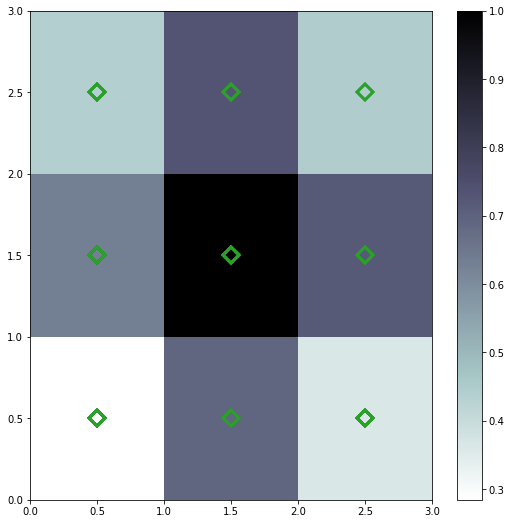

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

In [26]:
import altair as alt
u_matrix2 = som.distance_map('mean')
u_matrix2 = pd.DataFrame(u_matrix2).stack().rename_axis(['Y', 'X']).reset_index(name='DISTANCE')
alt.Chart(u_matrix2,width=400,height=400).mark_rect().encode(
    x='X:O',
    y='Y:O',
    color=alt.Color('DISTANCE:Q', scale=alt.Scale(scheme='inferno')),
)

alt.Chart(...)